In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [25]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    Dense(117,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [27]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 133426 images belonging to 117 classes.
Found 29568 images belonging to 117 classes.


In [28]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Andorra: 0.0
Gibraltar: 0.0
Macao: 0.0
United States of America: 1.7073339925126307e-06
France: 7.590152229616502e-06
India: 9.194793117295176e-06
Russian Federation: 9.236000176867263e-06
Brazil: 1.0749903584896045e-05
Canada: 1.0804468972689806e-05
Australia: 1.3248819040356339e-05
Italy: 1.598445241675568e-05
Japan: 1.6190718835626527e-05
Spain: 1.6719200209849693e-05
Thailand: 1.7043808697793365e-05
U.K. of Great Britain and Northern Ireland: 1.732741145157313e-05
Poland: 1.904736732744809e-05
Sweden: 2.165679989795965e-05
Mexico: 2.298929695562407e-05
Indonesia: 2.3402108825546448e-05
Norway: 3.4107615452359266e-05
Argentina: 3.535287565782128e-05
Finland: 3.809167830782598e-05
South Africa: 4.3568617081038415e-05
Turkey: 4.542235472892782e-05
Ireland: 4.830864670556858e-05
Philippines: 5.055873994554051e-05
Romania: 5.335597452951564e-05
Czech Republic: 5.895155853689897e-05
New Zealand: 6.208912279456622e-05
Portugal: 7.248652479839605e-05
Denmark: 7.301095142750588e-05
Greece: 

C:\Users\21thebes\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=2000,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=200,
    class_weight = class_weights,
    verbose=1
    )


Epoch 1/5
2000/2000 [==============================] - 429s 214ms/step - loss: 2.4384e-04 - categorical_accuracy: 0.0010 - val_loss: 4.6449 - val_categorical_accuracy: 0.0011
Epoch 2/5
2000/2000 [==============================] - 480s 240ms/step - loss: 2.4087e-04 - categorical_accuracy: 5.6262e-04 - val_loss: 4.6590 - val_categorical_accuracy: 0.0011
Epoch 3/5
2000/2000 [==============================] - 510s 255ms/step - loss: 2.3863e-04 - categorical_accuracy: 0.0109 - val_loss: 4.6560 - val_categorical_accuracy: 4.6875e-04
Epoch 4/5
2000/2000 [==============================] - 428s 214ms/step - loss: 2.3063e-04 - categorical_accuracy: 0.0486 - val_loss: 4.6427 - val_categorical_accuracy: 0.2750
Epoch 5/5
2000/2000 [==============================] - 503s 252ms/step - loss: 2.4623e-04 - categorical_accuracy: 0.0479 - val_loss: 4.6583 - val_categorical_accuracy: 0.0027


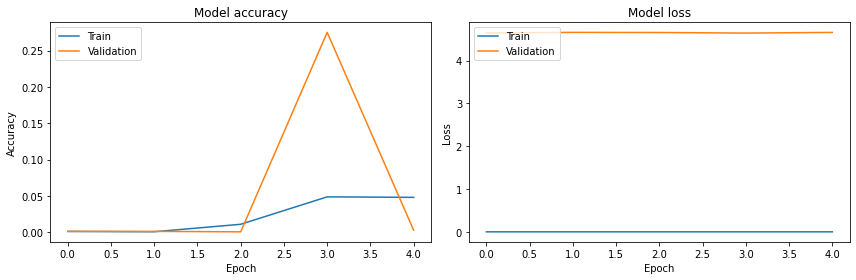

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
model.save('my_model.h5')


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\test'
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical')

class_names = generator.class_indices.keys()
#print(class_names)

Found 29438 images belonging to 117 classes.


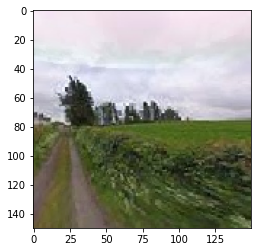

Country: ['Kenya'], Probability: 0.0099072540178895
Country: ['Hungary'], Probability: 0.0098361074924469
Country: ['Turkey'], Probability: 0.009799737483263016
Country: ['Greenland'], Probability: 0.009772210381925106
Country: ['Switzerland'], Probability: 0.009771161712706089
Country: ['Ukraine'], Probability: 0.009685978293418884
Country: ['Mongolia'], Probability: 0.00968187116086483
Country: ['Norway'], Probability: 0.009647181257605553
Country: ['Spain'], Probability: 0.009645386599004269
Country: ['Latvia'], Probability: 0.00963620375841856
Country: ['United States of America'], Probability: 0.009626691229641438
Country: ['Lesotho'], Probability: 0.009613312780857086
Country: ['West Bank'], Probability: 0.009610607288777828
Country: ['Bolivia'], Probability: 0.009603883139789104
Country: ['Lithuania'], Probability: 0.009577464312314987
Country: ['Philippines'], Probability: 0.009571569971740246
Country: ['Czech Republic'], Probability: 0.009563766419887543
Country: ['India'], Pr

In [33]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Ireland\-k1VSj7m5z79IEH3idNLyA.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [34]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



1.15.8
GPU found
